### Setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import glob
import os

from scipy.io import loadmat

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load calibration (Intrinsics & Extrinsics)

In [ ]:
data = loadmat('Calib_Results_left.mat')

# Intrinsics
fc = data['fc']          # focal lengths
cc = data['cc']          # principal point
kc = data['kc']          # distortion coefficients

fx, fy = fc[0][0], fc[1][0]
cx, cy = cc[0][0], cc[1][0]
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=np.float64)

distCoeffs = kc.flatten()

In [3]:
# Extrinsics
omc_1 = data['omc_1'].flatten()     # rodrigues vector 3*1
Tc_1  = data['Tc_1'].flatten()
R_1, _ = cv.Rodrigues(omc_1)        # rotation vector 3*3
t_1 = Tc_1.reshape((3,1))           # translation vector 

### Load Images

In [4]:
folder = "media/3D-reconstruction/subset_scan6/*.png"

file_list = sorted(glob.glob(folder))
images = []

for filepath in file_list:
    filename = os.path.basename(filepath)
    img = cv.imread(filepath)
    if img is not None:
        images.append(img)

print(f"Loaded {len(images)} images in order.")

Loaded 49 images in order.


### Undistort Images

In [5]:
height, width = images[0].shape[:2]
newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(K , distCoeffs, (width,height), 1, (width,height))

dimages = []
for img in images:
    distImg = cv.undistort(img, K, distCoeffs, None, newCameraMatrix)

    # crop images
    x, y, w, h = roi # region of interest
    distImg = distImg[y:y+h, x:x+w]
    
    dimages.append(distImg)

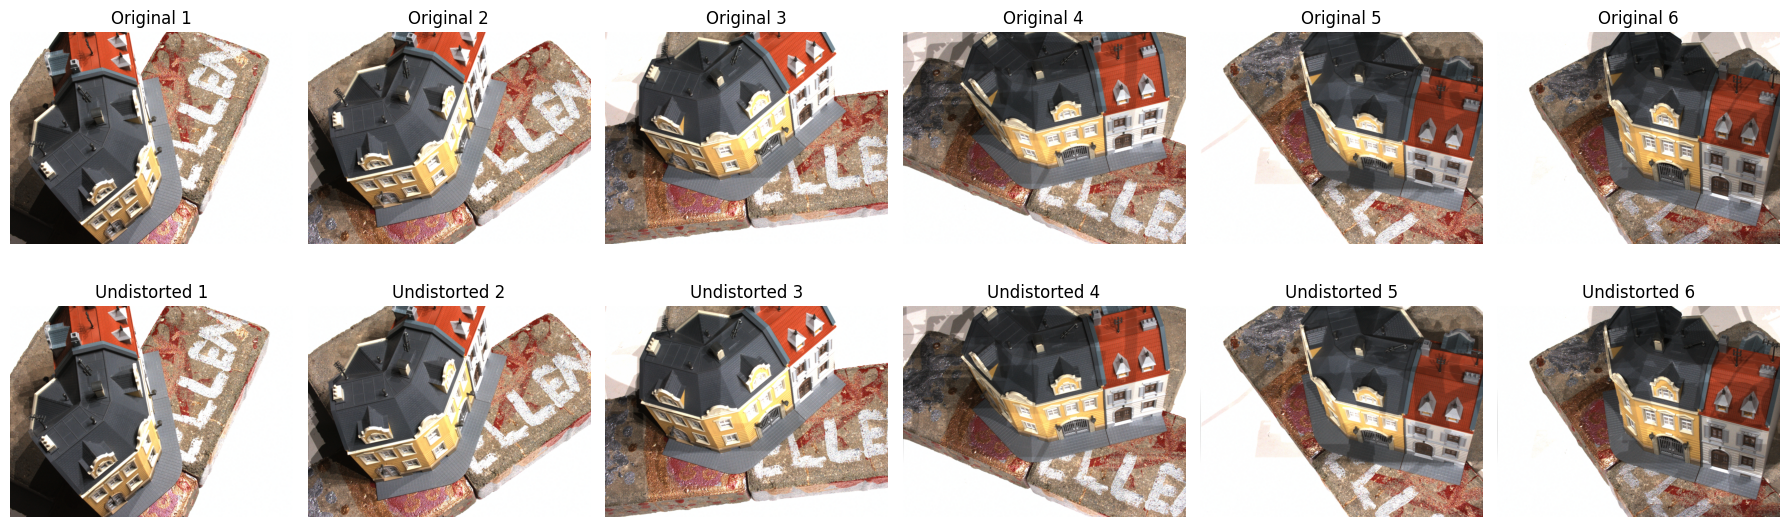

In [6]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(6):
    axes[0, i].imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(cv.cvtColor(dimages[i], cv.COLOR_BGR2RGB))
    axes[1, i].set_title(f"Undistorted {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

### Feature Extraction

In [7]:
sift = cv.SIFT_create()

keypoints = []
descriptors = []

for img in dimages:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)


### Feature Matching

In [8]:
bf = cv.BFMatcher()
all_matches = []

for i in range(len(dimages) - 1):
    matches = bf.knnMatch(descriptors[i], descriptors[i+1], k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    all_matches.append((i, i+1, good))
    print(f"Image {i} ↔ Image {i+1}: {len(good)} good matches")


Image 0 ↔ Image 1: 3179 good matches
Image 1 ↔ Image 2: 3254 good matches
Image 2 ↔ Image 3: 2963 good matches
Image 3 ↔ Image 4: 2089 good matches
Image 4 ↔ Image 5: 1435 good matches
Image 5 ↔ Image 6: 1302 good matches
Image 6 ↔ Image 7: 1751 good matches
Image 7 ↔ Image 8: 2950 good matches
Image 8 ↔ Image 9: 3530 good matches
Image 9 ↔ Image 10: 3206 good matches
Image 10 ↔ Image 11: 1891 good matches
Image 11 ↔ Image 12: 2468 good matches
Image 12 ↔ Image 13: 2762 good matches
Image 13 ↔ Image 14: 3169 good matches
Image 14 ↔ Image 15: 3356 good matches
Image 15 ↔ Image 16: 2475 good matches
Image 16 ↔ Image 17: 1816 good matches
Image 17 ↔ Image 18: 1223 good matches
Image 18 ↔ Image 19: 442 good matches
Image 19 ↔ Image 20: 403 good matches
Image 20 ↔ Image 21: 979 good matches
Image 21 ↔ Image 22: 1884 good matches
Image 22 ↔ Image 23: 2630 good matches
Image 23 ↔ Image 24: 3160 good matches
Image 24 ↔ Image 25: 3031 good matches
Image 25 ↔ Image 26: 2639 good matches
Image 26

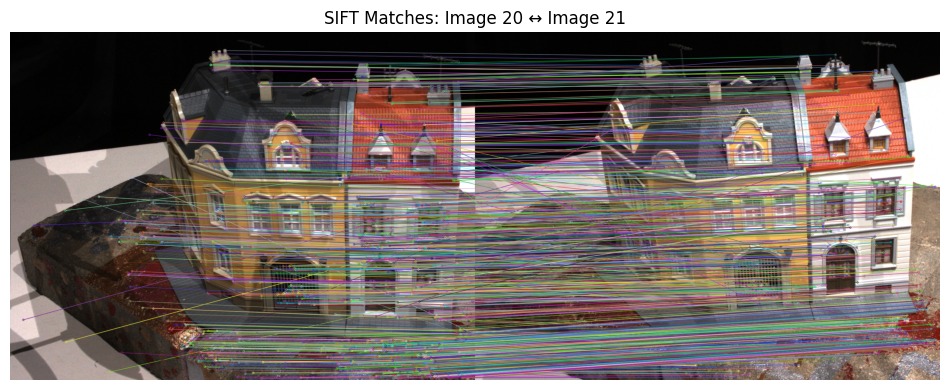

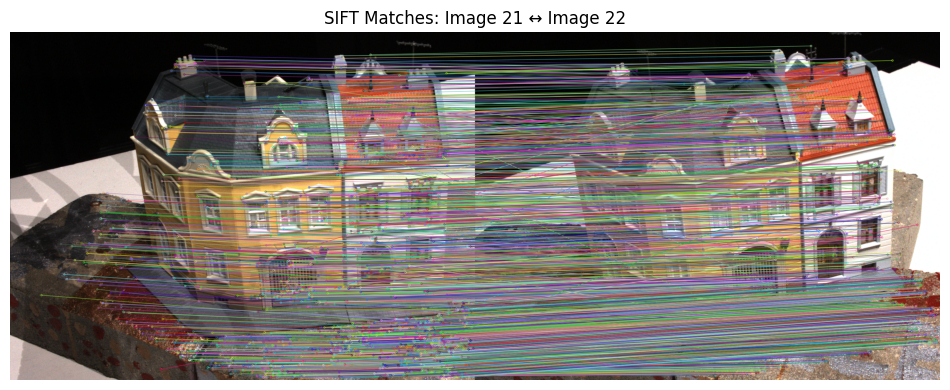

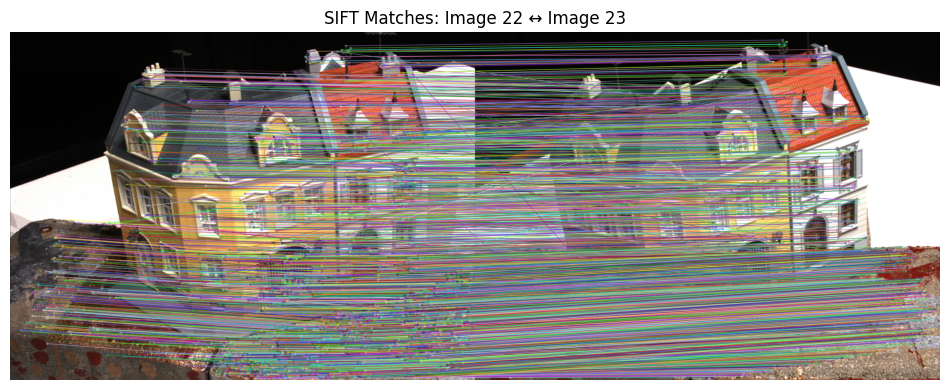

In [9]:
for (i, j, good) in all_matches[20:23]:
    img_matches = cv.drawMatches(
        dimages[i], keypoints[i],
        dimages[j], keypoints[j],
        good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(12,6))
    plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
    plt.title(f"SIFT Matches: Image {i} ↔ Image {j}")
    plt.axis("off")
    plt.show()


### Two-view Reconstruction

#### Find Essential Matrix, Rotation & Translation

In [10]:
i, j, good = all_matches[0]

points1 = np.float32([ keypoints[i][m.queryIdx].pt for m in good ])
points2 = np.float32([ keypoints[j][m.trainIdx].pt for m in good ])

E, mask = cv.findEssentialMat(points1, points2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)
_, R, t, mask_pose = cv.recoverPose(E, points1, points2, K, mask=mask)

#### Triangulation

In [11]:
projMat1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
projMat2 = K @ np.hstack((R, t))     

points1_in = points1[mask.ravel()==1].T             # inlier points1
points2_in = points2[mask.ravel()==1].T             # inlier points2

points_h = cv.triangulatePoints(projMat1, projMat2, points1_in, points2_in)     # homogeneous points
points_3d = (points_h[:3] / points_h[3]).T
print("Triangulated points:", points_3d.shape)

Triangulated points: (2977, 3)


In [12]:
# track_2d_to_3d: links 2D keypoint indices to their corresponding 3D point indices
track_2d_to_3d = {} 

good_matches1 = all_matches[0][2]
for i, m in enumerate(np.array(good_matches1)[mask_pose.ravel()==1]):
    kp_idx_prev = m.queryIdx
    kp_idx_curr = m.trainIdx

    track_2d_to_3d[kp_idx_prev] = i
    track_2d_to_3d[kp_idx_curr] = i 

### Incremental SfM
estimate poses and triangulate new points

In [ ]:
# first camera pose
rotations = [np.eye(3)]
translations = [np.zeros((3,1))]

# second camera pose
rotations.append(R)
translations.append(t)

for idx in range(2, len(dimages)):
    kp_new = keypoints[idx]
    des_new = descriptors[idx]

    # match features between new image and prev image
    matches = bf.knnMatch(descriptors[idx-1], des_new, k=2)
    good = [m for m,n in matches if m.distance < 0.75*n.distance]

    # collect 2D-3D correspondences
    pts3d_list, pts2d_list = [], []
    for m in good:
        kp_prev_id = m.queryIdx
        kp_curr_id = m.trainIdx
        if kp_prev_id in track_2d_to_3d:
            p3d_idx = track_2d_to_3d[kp_prev_id]
            if p3d_idx < len(points_3d):
                pts3d_list.append(points_3d[p3d_idx])
                pts2d_list.append(kp_new[kp_curr_id].pt)

    if len(pts3d_list) < 6:
        print(f"Too few 2D-3D matches for image {idx}")
        continue

    # pose estimation with PnP for new camera
    pts3d_arr = np.array(pts3d_list, dtype=np.float32)
    pts2d_arr = np.array(pts2d_list, dtype=np.float32)

    # solvePnP
    _, rvec, tvec, inliers = cv.solvePnPRansac(pts3d_arr, pts2d_arr, K, distCoeffs)
    R_new, _ = cv.Rodrigues(rvec)
    t_new = tvec
    rotations.append(R_new)
    translations.append(t_new)


    #find unmatched keypoints for triangulation
    pts_prev, pts_curr, new_matches = [], [], []
    for m in good:
        kp_prev_id = m.queryIdx
        kp_curr_id = m.trainIdx

        if kp_curr_id not in track_2d_to_3d:
            pts_prev.append(keypoints[idx-1][kp_prev_id].pt)
            pts_curr.append(kp_new[kp_curr_id].pt)
            new_matches.append(m)

    if len(pts_prev) > 0:

        # triangulate new points
        pts_prev_in = np.float32(pts_prev).T
        pts_curr_in = np.float32(pts_curr).T

        P_prev = K @ np.hstack((rotations[idx-1], translations[idx-1]))
        P_curr = K @ np.hstack((R_new, t_new))

        points_h = cv.triangulatePoints(P_prev, P_curr, pts_prev_in, pts_curr_in)
        new_pts3d = (points_h[:3] / points_h[3]).T

        # update 3D cloud and mapping
        base_idx = len(points_3d)
        points_3d = np.vstack([points_3d, new_pts3d])

        for m, p3d_idx in zip(new_matches, range(len(new_pts3d))):
            track_2d_to_3d[m.trainIdx] = base_idx + p3d_idx

#### Save point cloud

In [18]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

colors = np.random.rand(points_3d.shape[0], 3)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("reconstruction2.ply", pcd)

True